In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from probabilistic_criterion.dataset import FDB

## Model

$$\log\left(N\right) \vert_{P_c, \tau_c} = a - b\, \log\left(\alpha\,P_c + \tau_c\right) + \sigma\, \varepsilon\ .$$

+ $\varepsilon \sim \mathcal{N}(0,1)$
+ Parameter: $\theta = (a, b, \alpha, \sigma)$
+ Notation: $x=(p_c, \tau_c)$ and $h(x, \theta) = a - b\, \log\left(\alpha\,P_c + \tau_c\right) $

## Log-likelihood and derivatives

In [2]:
# Constants
N = int(10**6)        # Target lifetime
ninc = int(3*10**5)   # Locati interval between load increment

In [3]:
# h function and its derivatives
def h(x, theta):
    return theta[0] - theta[1]*np.log(max(theta[2]*x[0] + x[1],1e-10))

def dh(x, theta):
    return np.array([1, -np.log(max(theta[2]*x[0] + x[1],1e-10)), -theta[1]*x[0]/(max(theta[2]*x[0] + x[1],1e-10))])

def d2h(x, theta):
    H = np.zeros((3,3))
    H[1,2] = -x[0]/(theta[2]*x[0] + x[1])
    H[2,1] = -x[0]/(theta[2]*x[0] + x[1])
    H[2,2] = theta[1]*(x[0]/(max(theta[2]*x[0] + x[1],1e-10)))**2
    return H

In [4]:
# Log-likelihood and its derivatives

def loglike(z, delta, x, theta, v):
    l = -((1-delta)/2*(np.log(2*np.pi * v) + (z-h(x,theta))**2/v) - delta*scs.norm.logcdf(-h(x,theta)/np.sqrt(v)))
    return l

def dPsi(x):
    return scs.norm.pdf(x)/scs.norm.cdf(x)

def dphi(x):
    return -1/np.sqrt(2*np.pi)*x*np.exp(-x**2/2)

def d2Psi(x):
    return dphi(x)/scs.norm.cdf(x)-dPsi(x)**2

def dloglike(z, delta, x, theta, v):
    C = 1/np.sqrt(v)*((1-delta)*(z-h(x,theta))/np.sqrt(v) - delta*dPsi(-h(x,theta)/np.sqrt(v)))
    dv = 1/v*((1-delta)/2*((z-h(x,theta))**2/v - 1) + delta*h(x,theta)/(2*np.sqrt(v))*dPsi(-h(x, theta)/np.sqrt(v)))
    dl = np.zeros(4)
    dl[:3] = C*dh(x, theta)
    dl[3] = dv
    return dl

def d2loglike(z, delta, x, theta, v):
    d2l = np.zeros((4,4))
    s = np.sqrt(v)
    C1 = 1/s*((1-delta)*(z-h(x,theta))/s - delta*dPsi(-h(x,theta)/s))
    C2 = -1/v*((1-delta) - delta*d2Psi(-h(x,theta)/s))
    C3 = (1/s)**3*(-(1-delta)*(z-h(x,theta))/s + delta/2*(dPsi(-h(x,theta)/s) - h(x,theta)*d2Psi(-h(x,theta)/s)))
    d2l[:3,:3] =  C1*d2h(x,theta) + C2*np.dot(dh(x,theta)[:,np.newaxis], dh(x,theta)[np.newaxis,:])
    d2l[:3,3] = C3*dh(x, theta)
    d2l[3,:3] = C3*dh(x, theta)
    return d2l

def I1(x, theta, v):
    s = np.sqrt(v)
    C1 = 1/v*(1 - (1+d2Psi(-h(x,theta)/s))*scs.norm.cdf(-h(x,theta)/s))
    return C1 * np.dot(dh(x,theta)[:,np.newaxis], dh(x,theta)[np.newaxis,:])

## Loading experimental data

In [5]:
df = pd.read_csv("data/coupons_Fayard.csv")

In [6]:
df

,Structure,N2(30%),pmax,tau,ninc,F0
0,A10,47000.0,147.000000,139.50,0,1
1,A12,1350000.0,89.833333,85.25,0,1
2,A13,519000.0,98.000000,93.00,0,1
3,A14,25000.0,147.000000,139.50,0,1
4,A15,44000.0,147.000000,139.50,0,1
...,...,...,...,...,...,...
139,F5,98500.0,220.000000,92.40,0,1
140,F6,66000.0,220.000000,92.40,0,1
141,F7,43500.0,220.000000,92.40,0,1
142,F8,63000.0,220.000000,92.40,0,1


In [7]:
X = df[['pmax', 'tau']].values
Y = np.log(df['N2(30%)'].values)

In [8]:
len(df)

144

In [9]:
def loglike_(theta):
    return -np.sum([loglike(Y[k], 0, X[k], theta[:3], max(theta[3],1e-10)) for k in range(X.shape[0])])
def dloglike_(theta):
    return -np.sum([dloglike(Y[k], 0, X[k], theta[:3], max(theta[3],1e-10)) for k in range(X.shape[0])], axis=0)
def d2loglike_(theta):
    return -np.sum([d2loglike(Y[k], 0, X[k], theta[:3], max(theta[3],1e-10)) for k in range(X.shape[0])], axis=0)
def I_(theta):
    return np.sum([I1(X[k], theta[:3], max(theta[3],1e-10)) for k in range(X.shape[0])], axis=0)

## Maximizing the log-likelihood

(minimizing the opposite of the log-likelihood)

In [10]:
# May require a few minutes
# Starting parameters are chosen neutral (b=8, alpha=0.5, ...) -> still realistic regarding the application
# One may start from arbitrary coefficient respecting the boundary conditions, however it may require more iterations to converge properly (can be done with commented cell below)
res = minimize(loglike_, np.array([35,  8,  0.35,  0.5]), method='Newton-CG', options={'maxiter':1000}, jac=dloglike_, hess=d2loglike_)

/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/4267941827.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return scs.norm.pdf(x)/scs.norm.cdf(x)
/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/4267941827.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return scs.norm.pdf(x)/scs.norm.cdf(x)


In [11]:
# Start from arbitrary parameters -> need to increase the number of iterations to effectively achieve convergence
# Note that this will require more time
# res = minimize(loglike_, np.array([0.,  1.,  0.,  1.]), method='Newton-CG', options={'maxiter':10000}, jac=dloglike_, hess=d2loglike_, bounds = [(-np.inf,np.inf), (0, np.inf), (-1, 1), (1e-10, np.inf)])

In [12]:
res

     fun: 162.31682538125156
     jac: array([-0.00841718,  0.01011463, -0.00230725, -0.01454862])
 message: 'Optimization terminated successfully.'
    nfev: 800
    nhev: 742
     nit: 742
    njev: 797
  status: 0
 success: True
       x: array([37.21623492,  4.93562271,  0.35326512,  0.55791375])

In [13]:
# Calculating the Hessian
V = np.linalg.inv(I_(res.x))

In [14]:
# Standard deviation on the estimation of the parameters
s = np.sqrt(np.diag(V))

In [15]:
# Standard deviation on the parameter sigma
s_sig = np.sqrt(2*res.x[3]**2/len(Y))

In [16]:
# Normal quantiles at level 0.95
alpha = 0.05
q = scs.norm.ppf(1-alpha/2)

In [17]:
# This reproduces Table 1 of the article
rows = []
rows.append(pd.Series({'inf 95%' : res.x[0]-q*s[0], 'mean' : res.x[0], 'sup 95%' : res.x[0]+q*s[0]}, name='a'))
rows.append(pd.Series({'inf 95%' : res.x[1]-q*s[1], 'mean' : res.x[1], 'sup 95%' : res.x[1]+q*s[1]}, name='b'))
rows.append(pd.Series({'inf 95%' : res.x[2]-q*s[2], 'mean' : res.x[2], 'sup 95%' : res.x[2]+q*s[2]}, name='alpha'))
rows.append(pd.Series({'inf 95%' : np.sqrt(res.x[3]-q*s_sig), 'mean' : np.sqrt(res.x[3]), 'sup 95%' : np.sqrt(res.x[3]+q*s_sig)}, name='sigma'))
df_res = pd.DataFrame(rows).round(2)
print(df_res)

       inf 95%   mean  sup 95%
a        34.37  37.22    40.06
b         4.39   4.94     5.48
alpha     0.26   0.35     0.44
sigma     0.66   0.75     0.83


In [18]:
# Latex table
print(df_res.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  inf 95\% &   mean &  sup 95\% \\
\midrule
a     &    34.37 &  37.22 &    40.06 \\
b     &     4.39 &   4.94 &     5.48 \\
alpha &     0.26 &   0.35 &     0.44 \\
sigma &     0.66 &   0.75 &     0.83 \\
\bottomrule
\end{tabular}



/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/1606582468.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_res.to_latex())


## Estimate of crack initiation probability before $10^6$ cycles

$$\widehat{p}\left(P_c, \tau_c\right) = \Phi\left(\frac{\log(N_0) -\widehat{a} + \widehat{b}\, \log\left(\widehat{\alpha}\,P_c + \tau_c\right)}{\widehat{\sigma}}\right)\ .$$


In [19]:
def proba(p, tau, theta, V):
    return scs.norm.cdf(1/np.sqrt(theta[3])*(-theta[0] + theta[1]*np.log(max(0,theta[2]*p + tau)) + np.log(10**6)))

## Mean criterion at $10^6$ cycles and confidence interval on the mean

In [20]:
def mean_crit(p, theta):
    return (np.exp(theta[0])/N)**(1/theta[1])-theta[2]*p

def dmean_crit(p, theta):
    d1 = 1/theta[1]*(np.exp(theta[0])/N)**(1/theta[1])
    d2 = -(theta[0]-np.log(N))/(theta[1]**2)*(np.exp(theta[0])/N)**(1/theta[1])
    d3 = -p
    return np.array([d1, d2, d3])

def std_mean_crit(p, theta, V):
    return np.sqrt(np.dot(np.dot(dmean_crit(p, res.x), V), dmean_crit(p, res.x)))

## Plot of the regression estimate in an SN-like diagram

Figure 4 in article

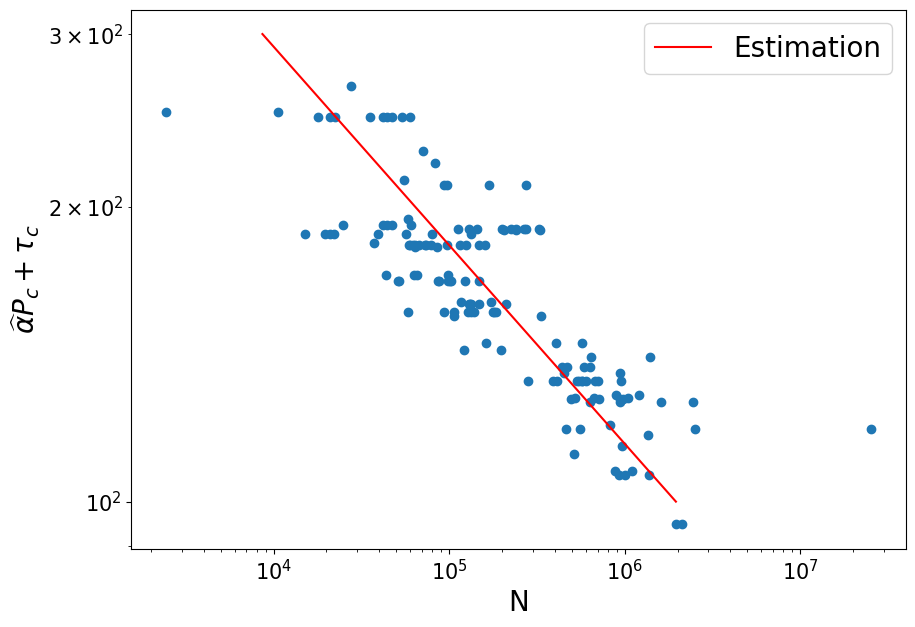

In [21]:
plt.figure(figsize=(10,7))
x1 = np.linspace(np.log(100), np.log(300))
y1 = res.x[0] - res.x[1]*x1
plt.scatter(np.exp(Y), X[:,0]*res.x[2]+X[:,1])
plt.plot(np.exp(y1), np.exp(x1), color='red', label='Estimation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N', fontsize=20)
plt.ylabel(r'$\widehat{\alpha}P_c + \tau_c$', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=15)
# plt.title(r'Courbe $\tau_0 - N$', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('figures/tau0.png', bbox_inches='tight')

## Estimate of fatigue lifetime in Dang Van diagram

/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/1849138658.py:7: RuntimeWarning: divide by zero encountered in log
  zz1 = np.exp(res.x[0] - res.x[1]*np.log(res.x[2]*xx + yy))


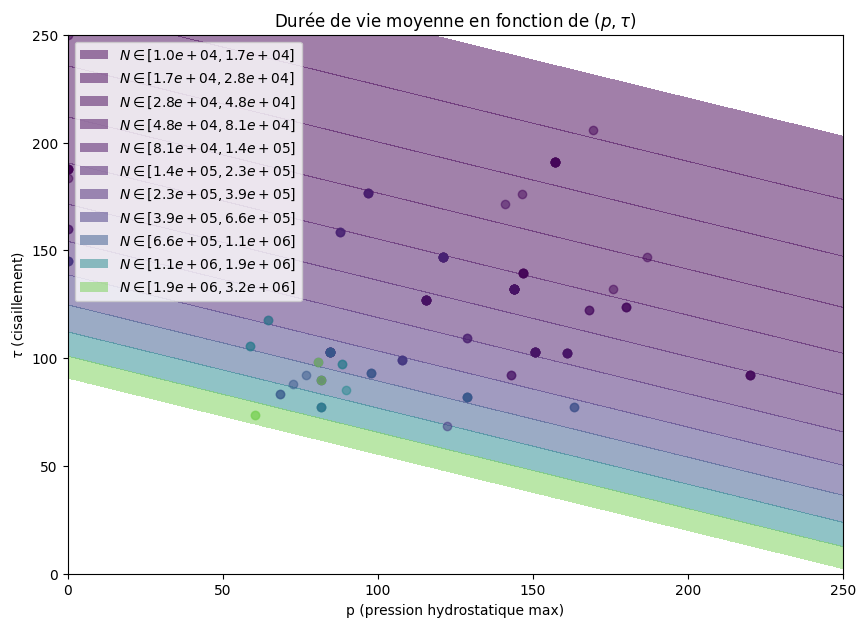

In [22]:
plt.figure(figsize=(10,7))
nx, ny = 100, 100
x_min, x_max = 0, 250
y_min, y_max = 0, 250
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
zz1 = np.exp(res.x[0] - res.x[1]*np.log(res.x[2]*xx + yy))
levels = 10**(np.linspace(4,6.5,12))
cs = plt.contourf(xx, yy, zz1, levels=levels, alpha=0.5)
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in cs.collections]
labels = []
for k in range(len(levels)-1):
    labels.append(r'$N \in [{:.1e},{:.1e}]$'.format(round(levels[k]), round(levels[k+1])))
    plt.scatter(df[(df['N2(30%)']>= levels[k])&(df['N2(30%)']< levels[k+1])].pmax, df[(df['N2(30%)']>= levels[k])&(df['N2(30%)']< levels[k+1])].tau, color=cs.collections[k].get_facecolor())
plt.legend(proxy, labels)
plt.xlabel('p (pression hydrostatique max)')
plt.ylabel(r'$\tau$ (cisaillement)')
plt.title(r'Durée de vie moyenne en fonction de $(p, \tau)$')
plt.savefig('figures/isoN.png')

## Plot of the probabilistic criterion and confidence interval on the mean

Figure 5 in article

/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/4150130114.py:2: RuntimeWarning: divide by zero encountered in log
  return scs.norm.cdf(1/np.sqrt(theta[3])*(-theta[0] + theta[1]*np.log(max(0,theta[2]*p + tau)) + np.log(10**6)))


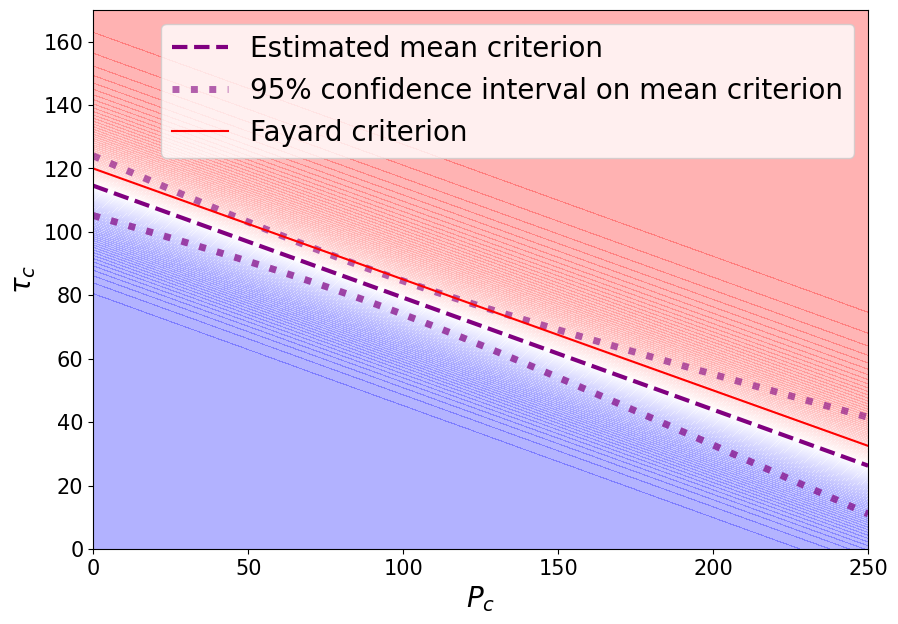

In [23]:
plt.figure(figsize=(10,7))
alpha = 0.05
q = scs.norm.ppf(1-alpha/2)
nx, ny = 100, 100
x_min, x_max = -0, 250
y_min, y_max = -0, 170
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
zz2 = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz2[i,j] = proba(xx[i,j], yy[i,j], res.x, V)
plt.contourf(xx, yy, zz2, levels=100, cmap="bwr", alpha=0.3)
# plt.contour(xx, yy, zz2, levels=[scs.norm.cdf(-3)])
xabs = np.linspace(-0,250,100)

plt.plot(xabs, [mean_crit(p, res.x) for p in xabs], label='Estimated mean criterion', color='purple', linewidth=3, linestyle='dashed')
plt.plot(xabs, [mean_crit(p, res.x) + q*std_mean_crit(p, res.x, V) for p in xabs], label='95% confidence interval on mean criterion', color='purple', linewidth=5, linestyle='dotted', alpha=0.6)
plt.plot(xabs, [mean_crit(p, res.x) - q*std_mean_crit(p, res.x, V) for p in xabs], color='purple', linewidth=5, linestyle='dotted', alpha=0.7)
plt.plot([-0,250], [120+0.35*0, 120-0.35*250], color='red', label='Fayard criterion')

# plt.scatter(df[(df['N2(30%)']< 10**6)].pmax, df[(df['N2(30%)']< 10**6)].tau, color='darkred', label=r'$N<10^6$', alpha=1, marker='*', s=200)
# plt.scatter(df[(df['N2(30%)']>= 10**6)].pmax, df[(df['N2(30%)']>= 10**6)].tau, color='darkblue', label=r'$N\geq10^6$', alpha=1, s=100)
plt.xlabel(r'$P_c$', fontsize=20)
plt.ylabel(r'$\tau_c$', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=15)
# plt.title(r'Evaluation de $\mathbb{P}(N \leq 10^6)$ en fonction de $(p, \tau)$')
plt.legend(fontsize=20)
plt.savefig('figures/isoP2.png')

## Plot of the probabilistic criterion with Fayard experiments

Figure 6 (left) in article

/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/4150130114.py:2: RuntimeWarning: divide by zero encountered in log
  return scs.norm.cdf(1/np.sqrt(theta[3])*(-theta[0] + theta[1]*np.log(max(0,theta[2]*p + tau)) + np.log(10**6)))


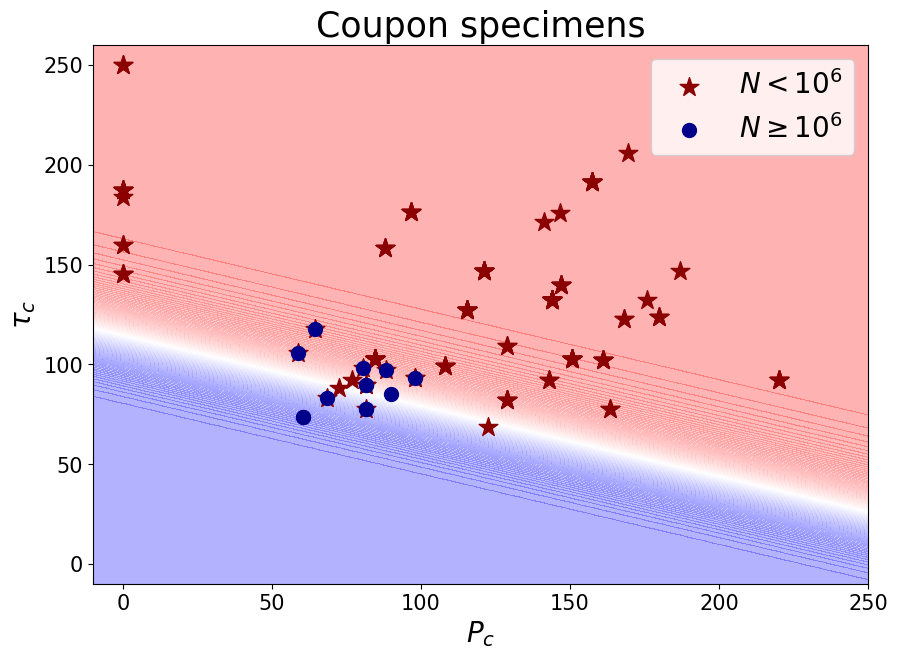

In [24]:
plt.figure(figsize=(10,7))
alpha = 0.05
q = scs.norm.ppf(1-alpha/2)
nx, ny = 100, 100
x_min, x_max = -10, 250
y_min, y_max = -10, 260
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
zz2 = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz2[i,j] = proba(xx[i,j], yy[i,j], res.x, V)
plt.contourf(xx, yy, zz2, levels=100, cmap="bwr", alpha=0.3)
xabs = np.linspace(-10,250,100)

plt.scatter(df[(df['N2(30%)']< 10**6)].pmax, df[(df['N2(30%)']< 10**6)].tau, color='darkred', label=r'$N<10^6$', alpha=1, marker='*', s=200)
plt.scatter(df[(df['N2(30%)']>= 10**6)].pmax, df[(df['N2(30%)']>= 10**6)].tau, color='darkblue', label=r'$N\geq10^6$', alpha=1, s=100)
plt.xlabel(r'$P_c$', fontsize=20)
plt.ylabel(r'$\tau_c$', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=15)
plt.legend(fontsize=20)
plt.title("Coupon specimens", fontsize=25)
plt.savefig('figures/isoP.png')

## Loading the database (components) and extract welds

In [25]:
# database = pd.read_csv("../../../Data/dataset3.2.csv", index_col=0)

In [26]:
# database[
# ['tresca_a_m_0_mean', 'sllbt_a_a_25_max', 'sttc_a_m_25_max', 'Tau0_25_mean', 'thickness_0_mean', 'p', 'tau', 'Tau0_0_mean', 'fn', 'f0', 'fm', 'N', 'Model', 'Zone', 'Epr', 'y', 'z']
# ].to_csv("data/fatigue_database.csv")

In [27]:
dataset = FDB('data/fatigue_database.csv', ['p', 'tau'], ['p', 'tau'], feature_norm='Tau0_0_mean')
dataset.prepare(random_state=0, factor=30)

In [28]:
indexes = dataset.data.index[dataset.data.Zone_type=='W']

In [29]:
ind0 = dataset.data.index[(dataset.data.Zone_type=='W')&(dataset.data.y==0)]
ind1 = dataset.data.index[(dataset.data.Zone_type=='W')&(dataset.data.y==1)]

## Plot of the probabilistic criterion with weld zones from the fatigue database

Figure 6 (right) in article

/var/folders/rv/fk7mqfps34b4jd5wtpm8gxb00000gn/T/ipykernel_39885/4150130114.py:2: RuntimeWarning: divide by zero encountered in log
  return scs.norm.cdf(1/np.sqrt(theta[3])*(-theta[0] + theta[1]*np.log(max(0,theta[2]*p + tau)) + np.log(10**6)))


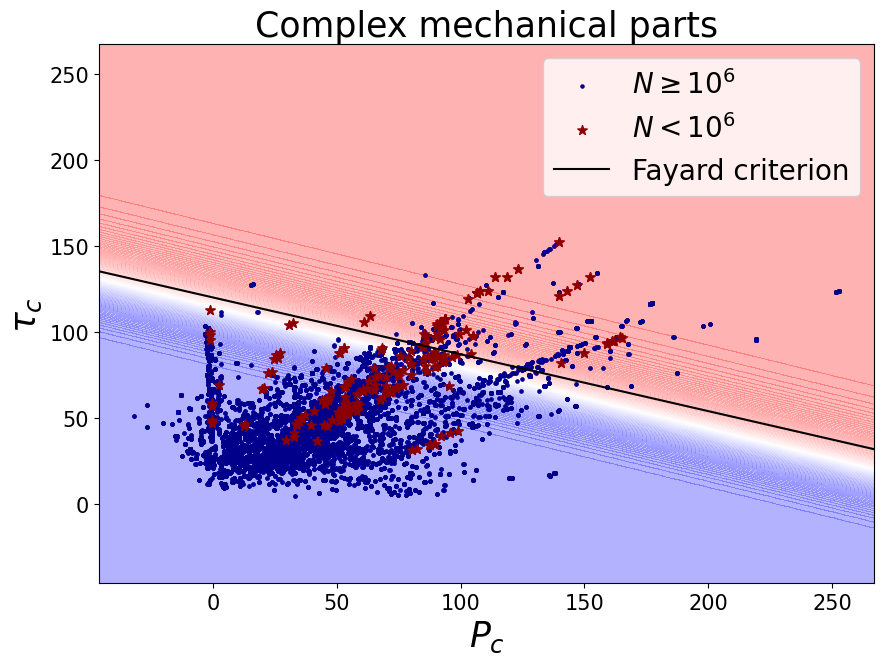

In [30]:
plt.figure(figsize=(10,7))
plt.scatter(dataset.Xeq[ind0, 0], dataset.Xeq[ind0, 1], color='blue', s=5)
plt.scatter(dataset.Xeq[ind1, 0], dataset.Xeq[ind1, 1], color='red', s=50, marker='*')
nx, ny = 100, 100
x_min, x_max = plt.gca().get_xlim()
y_min, y_max = plt.gca().get_xlim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
zz2 = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz2[i,j] = proba(xx[i,j], yy[i,j], res.x, V)
plt.contourf(xx, yy, zz2, levels=100, cmap="bwr", alpha=0.3)
plt.scatter(dataset.Xeq[ind0, 0], dataset.Xeq[ind0, 1], color='darkblue', s=5, label=r'$N\geq10^6$')
plt.scatter(dataset.Xeq[ind1, 0], dataset.Xeq[ind1, 1], color='darkred', s=50, marker='*', label=r'$N<10^6$')
# plt.contour(xx, yy, zz2, levels=[scs.norm.cdf(-3)])
plt.plot([x_min,x_max], [120-0.33*x_min, 120-0.33*x_max], color='black', label='Fayard criterion')
plt.xlabel(r'$P_c$', fontsize=25)
plt.ylabel(r'$\tau_c$', fontsize=25)
plt.tick_params(axis='both', which='both', labelsize=15)
# plt.title(r'Evaluation de $\mathbb{P}(N \leq 10^6)$ en fonction de $(p, \tau)$')
plt.legend(fontsize=20)
plt.title('Complex mechanical parts', fontsize=25)
plt.savefig('figures/isoP_prototypes.png')